In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import skew
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
import streamlit as st
import pickle 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
df=pd.read_csv("Copper_Set.csv")

C:\Users\THIRUMURUGAN\AppData\Local\Temp\ipykernel_14084\2495098720.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("Copper_Set.csv")


In [3]:
df['country'].unique()

array([ 28.,  25.,  30.,  32.,  38.,  78.,  27.,  77., 113.,  79.,  26.,
        39.,  40.,  84.,  80., 107.,  89.,  nan])

In [4]:
df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d',errors='coerce')

df.rename(columns={'quantity tons': 'quantity_tons'}, inplace=True)
df['quantity_tons']=df['quantity_tons'].replace('e',np.NaN).astype('float64').abs()
df['quantity_tons'] = df['quantity_tons'].map('{:.2f}'.format)
df['quantity_tons'] = pd.to_numeric(df['quantity_tons'], errors='coerce')

df.loc[df['material_ref'].astype(str).str.startswith('00000'), 'material_ref'] = None

df['product_ref'] = df['product_ref'].astype(str)

df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d',errors='coerce')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             181671 non-null  object        
 1   item_date      181670 non-null  datetime64[ns]
 2   quantity_tons  181672 non-null  float64       
 3   customer       181672 non-null  float64       
 4   country        181645 non-null  float64       
 5   status         181671 non-null  object        
 6   item type      181673 non-null  object        
 7   application    181649 non-null  float64       
 8   thickness      181672 non-null  float64       
 9   width          181673 non-null  float64       
 10  material_ref   81028 non-null   object        
 11  product_ref    181673 non-null  object        
 12  delivery date  181670 non-null  datetime64[ns]
 13  selling_price  181672 non-null  float64       
dtypes: datetime64[ns](2), float64(7), object(5)
memory u

In [6]:
mode=['item_date','customer','status','item type','application','material_ref','country','delivery date','product_ref']
mean=['quantity_tons','thickness','width','selling_price']
columns=list(df.columns) 


In [7]:
for i in columns:
  if i in mode:
    df[i].fillna(df[i].mode()[0],inplace=True)
  elif i in mean:
    df[i].fillna(df[i].mean(),inplace=True)

In [8]:
df.isnull().sum()

id               2
item_date        0
quantity_tons    0
customer         0
country          0
status           0
item type        0
application      0
thickness        0
width            0
material_ref     0
product_ref      0
delivery date    0
selling_price    0
dtype: int64

In [9]:
data_types = df.dtypes
    
# Check the distributions of continuous variables
continuous_columns = df.select_dtypes(include=[np.float64, np.int64]).columns

<function matplotlib.pyplot.show(close=None, block=None)>

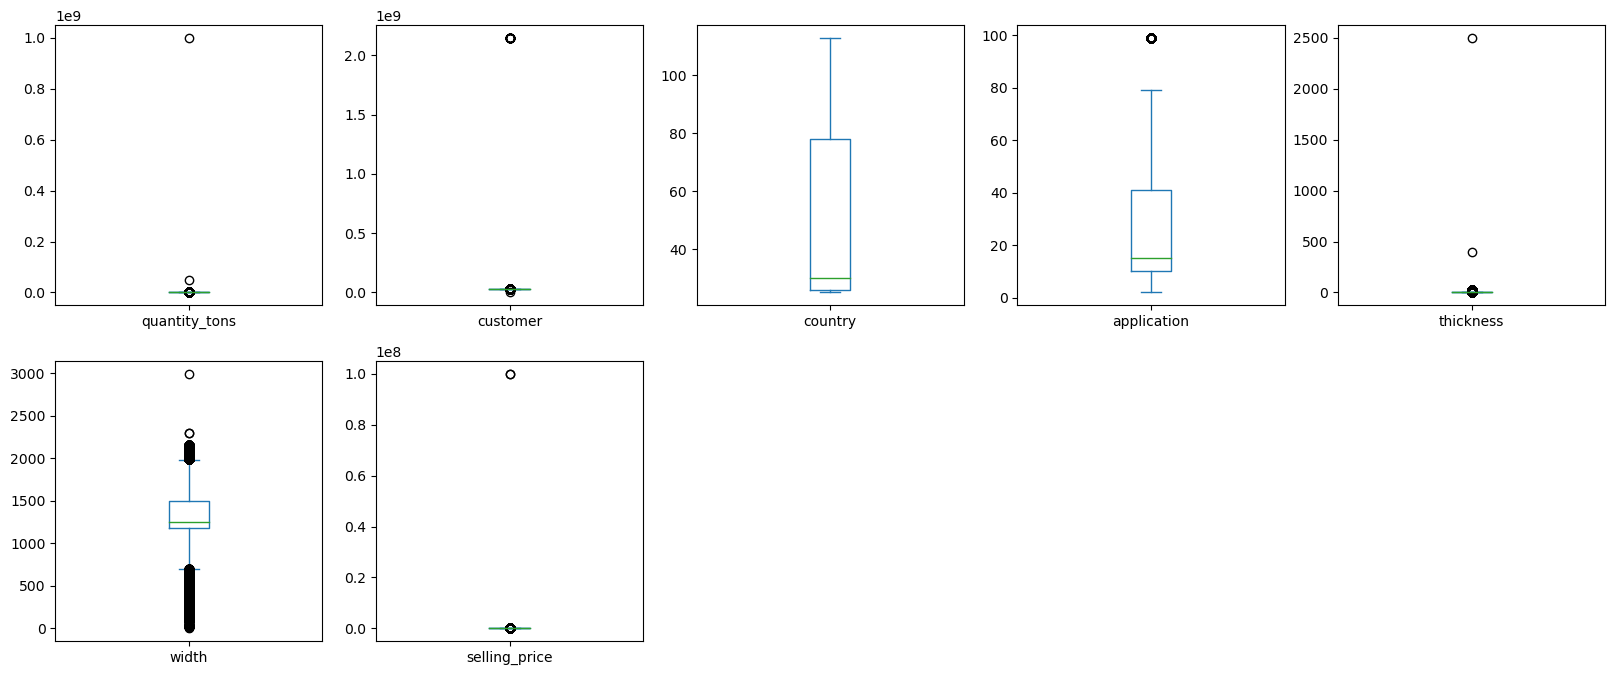

In [10]:
df.plot(kind='box',subplots=True,layout=(2,5),figsize=(20,8))
plt.show

In [11]:
df.skew()

C:\Users\THIRUMURUGAN\AppData\Local\Temp\ipykernel_14084\1665899112.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()


quantity_tons    424.690816
customer          86.985308
country            0.753090
application        0.724555
thickness        303.447634
width              0.374597
product_ref        1.015216
selling_price    301.388088
dtype: float64

In [12]:
q1 = df[continuous_columns].quantile(0.25)
q3 = df[continuous_columns].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[((df[continuous_columns] >= lower_bound) & (df[continuous_columns] <= upper_bound)).all(axis=1)]

<function matplotlib.pyplot.show(close=None, block=None)>

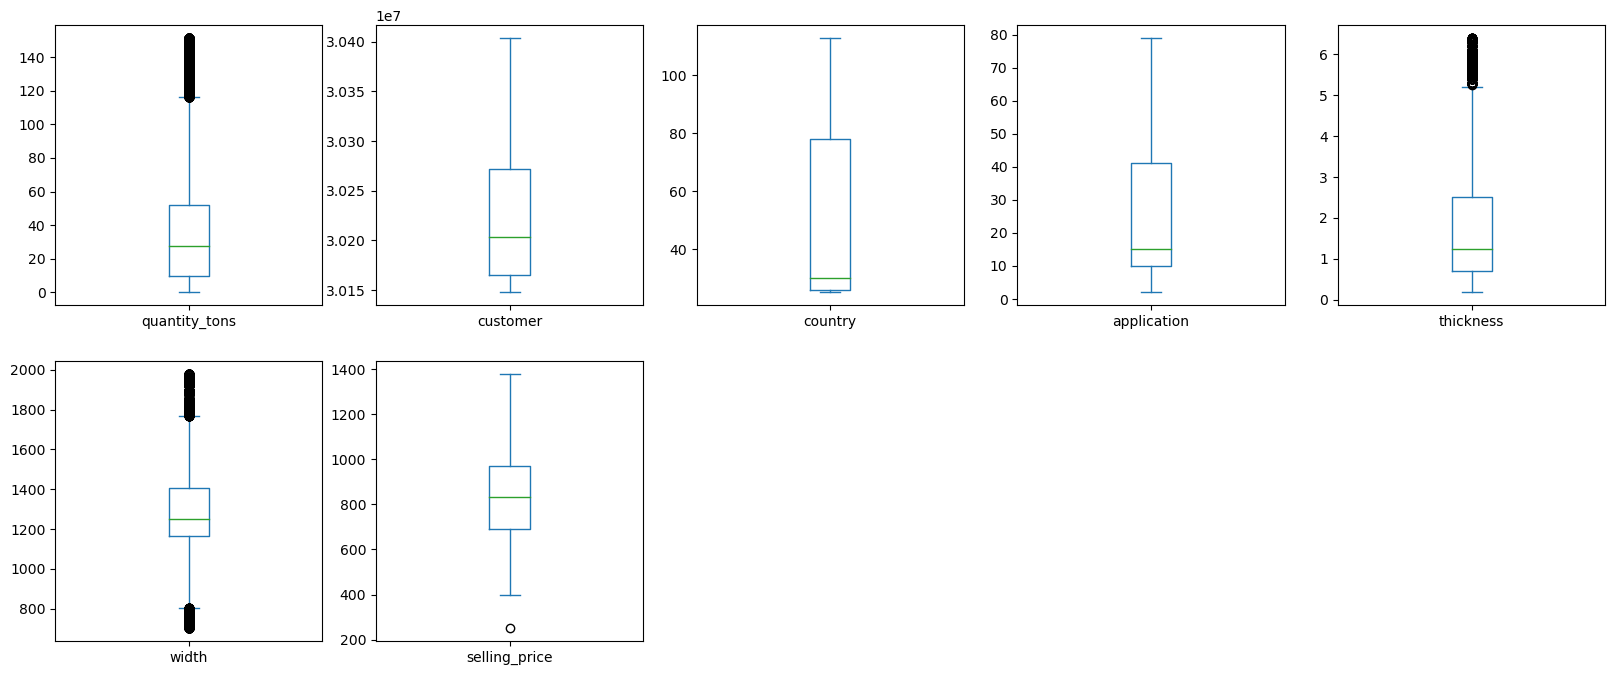

In [13]:
df.plot(kind='box',subplots=True,layout=(2,5),figsize=(20,8))
plt.show

In [14]:
skewness = df[continuous_columns].apply(lambda x: skew(x))
skewness

quantity_tons    1.298671
customer         0.979517
country          0.716469
application      0.670886
thickness        1.268868
width           -0.001027
selling_price    0.324371
dtype: float64

In [15]:
skewed_columns = skewness[skewness > 0.5].index
skewed_columns

Index(['quantity_tons', 'customer', 'country', 'application', 'thickness'], dtype='object')

Text(0.5, 1.0, 'Boxplot (Before Treatment)')

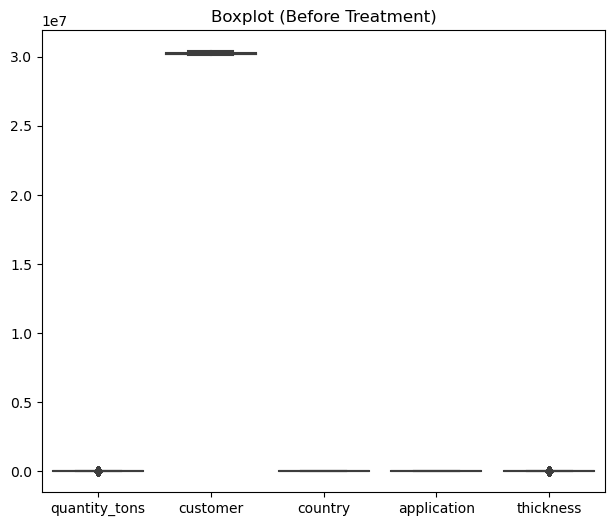

In [16]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df[skewed_columns])
plt.title("Boxplot (Before Treatment)")

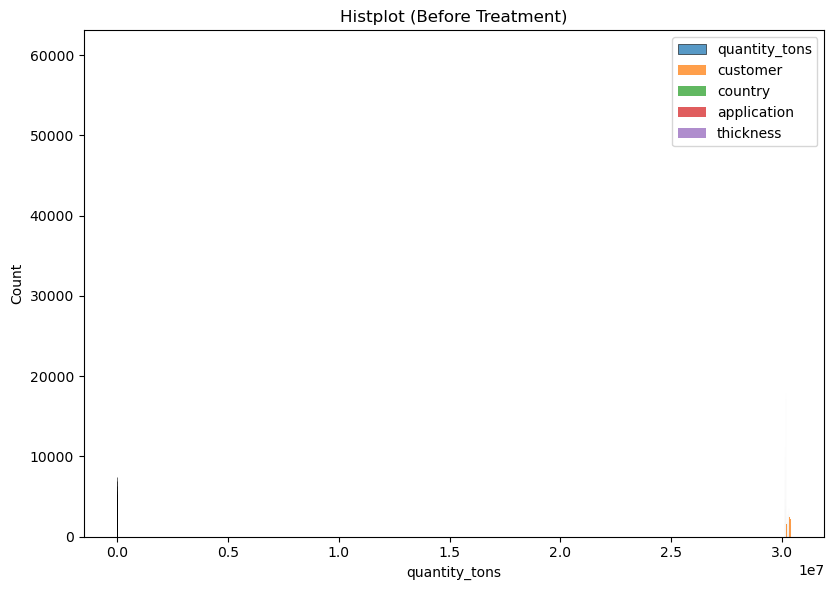

In [17]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
for col in skewed_columns:
    sns.histplot(df[col], label=col)
plt.legend()
plt.title("Histplot (Before Treatment)")
plt.tight_layout()
plt.show()

In [18]:
# Identify skewness and apply appropriate transformations

df[skewed_columns] = df[skewed_columns].apply(lambda x: np.log1p(x))

In [19]:
skewness = df[continuous_columns].apply(lambda x: skew(x))
skewness

quantity_tons   -0.483802
customer         0.976356
country          0.628680
application      0.205404
thickness        0.580292
width           -0.001027
selling_price    0.324371
dtype: float64

Text(0.5, 1.0, 'Boxplot (After Treatment)')

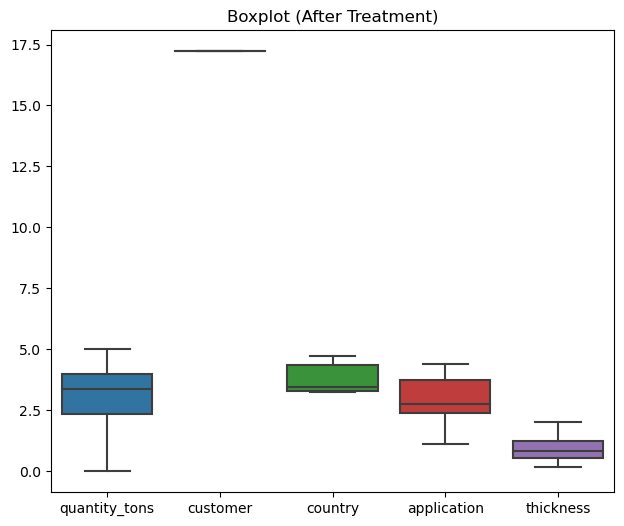

In [20]:
plt.figure(figsize=(16, 6))

# Boxplot after treatment
plt.subplot(1, 2, 1)
sns.boxplot(data=df[skewed_columns])
plt.title("Boxplot (After Treatment)")


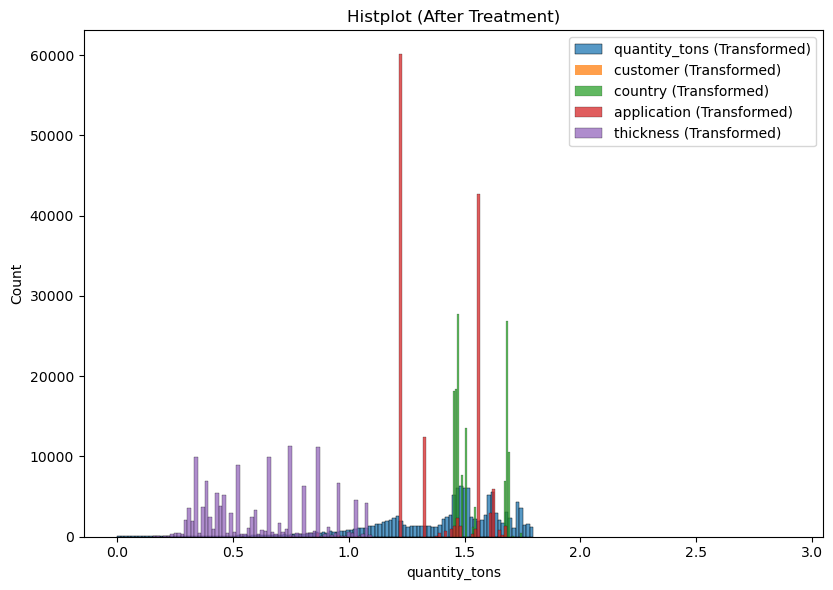

In [21]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
for col in skewed_columns:
    sns.histplot(np.log1p(df[col]), label=f"{col} (Transformed)")
plt.legend()
plt.title("Histplot (After Treatment)")
plt.tight_layout()
plt.show()

C:\Users\THIRUMURUGAN\AppData\Local\Temp\ipykernel_14084\3186384297.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


<Axes: >

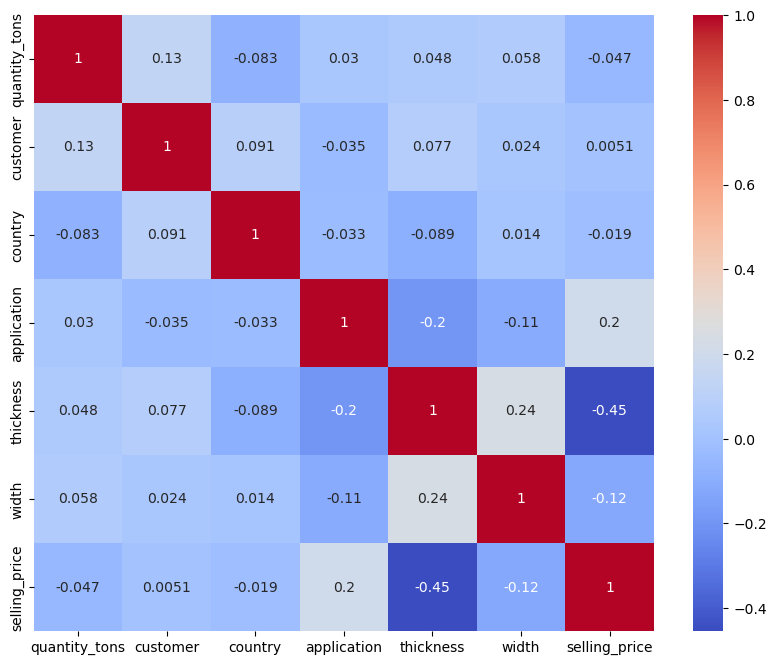

In [22]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [23]:
df

,id,item_date,quantity_tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,4.010057,17.221905,3.367296,Won,W,2.397895,1.098612,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.0
7,AA3F18A2-A7D6-43DE-8644-F0632AE2CB68,2021-04-01,4.739614,17.228050,3.496508,Won,W,3.737670,0.518794,1220.0,DX51D+Z,611993,2021-01-01,931.0
8,2851F48B-DA32-4DF3-884B-17A3100DD65A,2021-04-01,4.249495,17.228025,3.663562,Won,S,2.397895,0.470004,1275.0,DX51D+Z,1668701376,2021-07-01,1363.0
11,CA076845-2EDE-4C02-95BE-6C7B842026E8,2021-04-01,4.744932,17.228050,3.496508,Won,W,3.737670,0.438255,1220.0,DX51D+Z,611993,2021-01-01,954.0
12,EE7EE006-15B3-47A5-A48D-70D54C6B734C,2021-04-01,3.350255,17.222210,4.369448,Won,W,2.397895,0.559616,1250.0,DX51D+Z,164141591,2021-07-01,1098.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181665,F9B79E56-2EBF-417B-9802-7F575D1079F7,2020-07-02,1.969906,17.223381,3.258097,Won,W,3.737670,0.536493,1300.0,DX51D+Z,164141591,2020-07-01,608.0
181666,C01DE4E8-BC5F-42AD-B35F-8FCBEE34C6ED,2020-07-02,4.420285,17.223381,3.258097,Won,W,3.737670,0.779325,1220.0,DX51D+Z,164141591,2020-07-01,590.0
181667,0B812591-B501-4F34-859A-B06381FAEB44,2020-07-02,4.680092,17.223381,3.258097,Won,W,3.737670,0.672944,1240.0,DX51D+Z,164141591,2020-07-01,602.0
181668,DE633116-D1DF-4846-982E-55EFC3658A76,2020-07-02,4.639378,17.223381,3.258097,Won,W,3.737670,0.672944,1220.0,DX51D+Z,164141591,2020-07-01,591.0


In [24]:
df['delivery_period']=(df['item_date']-df['delivery date']).abs().dt.days
df.head()

,id,item_date,quantity_tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price,delivery_period
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,4.010057,17.221905,3.367296,Won,W,2.397895,1.098612,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.0,91
7,AA3F18A2-A7D6-43DE-8644-F0632AE2CB68,2021-04-01,4.739614,17.228050,3.496508,Won,W,3.737670,0.518794,1220.0,DX51D+Z,611993,2021-01-01,931.0,90
8,2851F48B-DA32-4DF3-884B-17A3100DD65A,2021-04-01,4.249495,17.228025,3.663562,Won,S,2.397895,0.470004,1275.0,DX51D+Z,1668701376,2021-07-01,1363.0,91
11,CA076845-2EDE-4C02-95BE-6C7B842026E8,2021-04-01,4.744932,17.228050,3.496508,Won,W,3.737670,0.438255,1220.0,DX51D+Z,611993,2021-01-01,954.0,90
12,EE7EE006-15B3-47A5-A48D-70D54C6B734C,2021-04-01,3.350255,17.222210,4.369448,Won,W,2.397895,0.559616,1250.0,DX51D+Z,164141591,2021-07-01,1098.0,91


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135217 entries, 0 to 181670
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               135215 non-null  object        
 1   item_date        135217 non-null  datetime64[ns]
 2   quantity_tons    135217 non-null  float64       
 3   customer         135217 non-null  float64       
 4   country          135217 non-null  float64       
 5   status           135217 non-null  object        
 6   item type        135217 non-null  object        
 7   application      135217 non-null  float64       
 8   thickness        135217 non-null  float64       
 9   width            135217 non-null  float64       
 10  material_ref     135217 non-null  object        
 11  product_ref      135217 non-null  object        
 12  delivery date    135217 non-null  datetime64[ns]
 13  selling_price    135217 non-null  float64       
 14  delivery_period  135

In [26]:
df['country'].unique()

array([3.36729583, 3.49650756, 3.66356165, 4.36944785, 3.33220451,
       3.4339872 , 3.25809654, 4.35670883, 4.38202663, 3.68887945,
       3.71357207, 3.29583687, 4.44265126, 4.39444915, 4.73619845,
       4.68213123, 4.49980967])

In [27]:
from sklearn.model_selection import train_test_split

x=df[['quantity_tons','country','application','thickness','width','delivery_period']].values
y=df[['selling_price']].values

In [28]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, Y_train, Y_test=train_test_split(x,y,test_size=0.3)



scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

# fit scaler on training data
#scaler = StandardScaler().fit(x)

#saving pickle file for scaling
#pickle.dump(scaler, open('scaling_regression.pkl', 'wb'))

# transform training data
#x = scaler.transform(x)

#spliting train and test
#X_train, X_test, Y_train, Y_test = train_test_split(x,y.reshape(-1),test_size=0.2)

Linear Regression - Mean Squared Error: 22817.0630, R-squared: 0.3673, Mean Absolute Error: 122.0622
ElasticNet - Mean Squared Error: 24610.6420, R-squared: 0.3176, Mean Absolute Error: 128.6352
LassoLars - Mean Squared Error: 22827.4271, R-squared: 0.3671, Mean Absolute Error: 122.2051
KNeighbors - Mean Squared Error: 15133.4261, R-squared: 0.5804, Mean Absolute Error: 92.0118
Decision Tree - Mean Squared Error: 13915.8640, R-squared: 0.6141, Mean Absolute Error: 71.6684
Extra Trees - Mean Squared Error: 7504.8060, R-squared: 0.7919, Mean Absolute Error: 57.2050


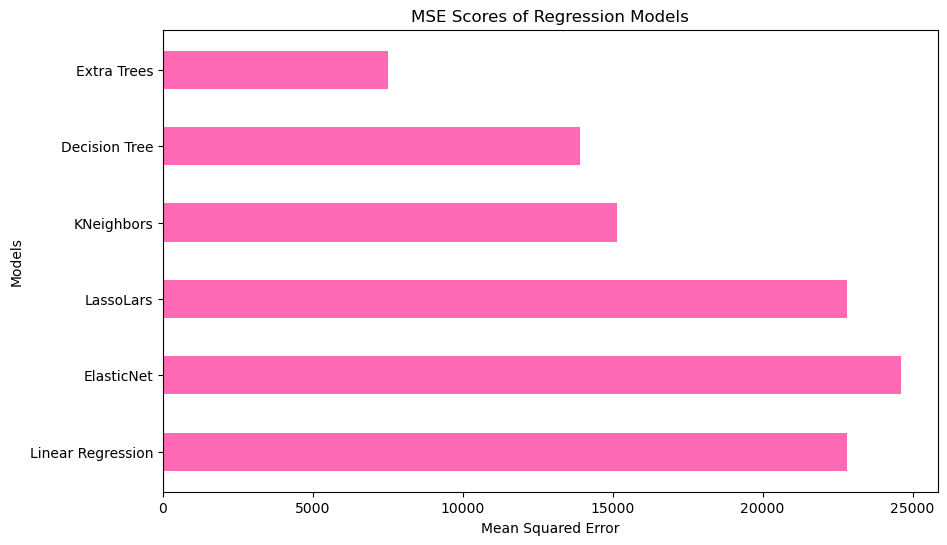

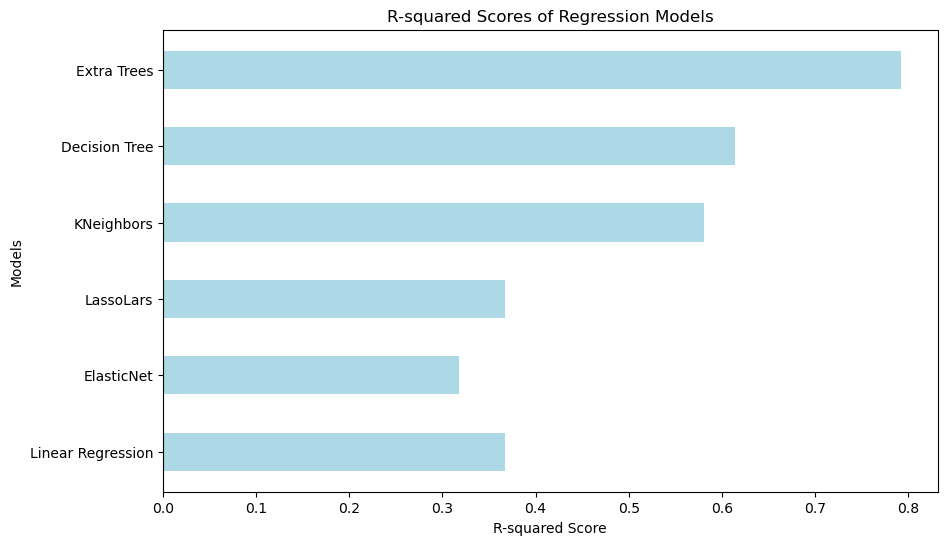

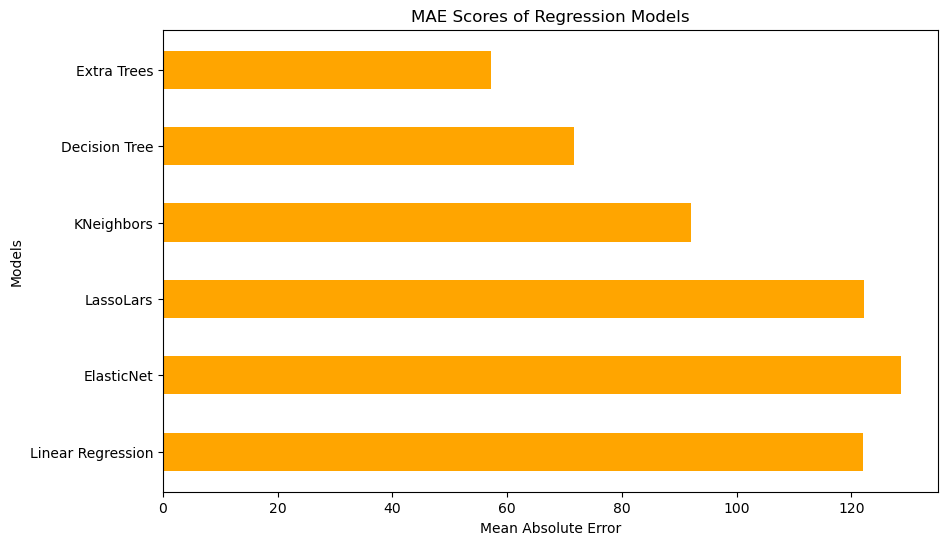

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, LassoLars
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pickle

# Load the dataset and perform necessary preprocessing
# ...

# Split the data into features (X) and target variable (y)
# X, y = ...

# Initialize the scaler and fit it on the training data
#scaler = StandardScaler().fit(X_train)

# Save the scaler using pickle
#with open('scaling_regression.pkl', 'wb') as f:
#    pickle.dump(scaler, f)

# Transform both training and testing data using the scaler
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

# Initialize the regression models

Y_train = Y_train.ravel()

models = [
    LinearRegression(),
    ElasticNet(),
    LassoLars(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    ExtraTreesRegressor()
]

# Train and evaluate each model
model_names = ['Linear Regression', 'ElasticNet', 'LassoLars', 'KNeighbors', 'Decision Tree', 'Extra Trees']
mse_scores = []
r2_scores = []
mae_scores = []
for model, model_name in zip(models, model_names):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    mae = mean_absolute_error(Y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)
    mae_scores.append(mae)
    print(f"{model_name} - Mean Squared Error: {mse:.4f}, R-squared: {r2:.4f}, Mean Absolute Error: {mae:.4f}")
# Create the bar plot for MSE scores
plt.figure(figsize=(10, 6))
plt.barh(model_names, mse_scores, height=0.5, color="hotpink")
plt.xlabel("Mean Squared Error")
plt.ylabel("Models")
plt.title("MSE Scores of Regression Models")

plt.show()

# Create the bar plot for R-squared scores
plt.figure(figsize=(10, 6))
plt.barh(model_names, r2_scores, height=0.5, color="lightblue")
plt.xlabel("R-squared Score")
plt.ylabel("Models")
plt.title("R-squared Scores of Regression Models")

plt.show()

# Create the bar plot for MAE scores
plt.figure(figsize=(10, 6))
plt.barh(model_names, mae_scores, height=0.5, color="orange")
plt.xlabel("Mean Absolute Error")
plt.ylabel("Models")
plt.title("MAE Scores of Regression Models")

plt.show()


In [30]:
model = ExtraTreesRegressor(n_estimators=100, criterion='friedman_mse', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=10, max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, bootstrap=False, oob_score=False, n_jobs=4, random_state=53, 
                            verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None).fit(X_train, Y_train)


In [32]:
Reg_model=pickle.dump(model,open('model1.pkl','wb'))
scale=pickle.dump(scaler,open('scale.pkl','wb'))

#Classification

In [33]:
df["status"].unique()

array(['Won', 'To be approved', 'Lost', 'Not lost for AM', 'Wonderful',
       'Revised', 'Offered', 'Offerable'], dtype=object)

In [34]:
df_classification=df.loc[df["status"].isin(['Won','Lost'])]
df_classification

,id,item_date,quantity_tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price,delivery_period
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,4.010057,17.221905,3.367296,Won,W,2.397895,1.098612,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.0,91
7,AA3F18A2-A7D6-43DE-8644-F0632AE2CB68,2021-04-01,4.739614,17.228050,3.496508,Won,W,3.737670,0.518794,1220.0,DX51D+Z,611993,2021-01-01,931.0,90
8,2851F48B-DA32-4DF3-884B-17A3100DD65A,2021-04-01,4.249495,17.228025,3.663562,Won,S,2.397895,0.470004,1275.0,DX51D+Z,1668701376,2021-07-01,1363.0,91
11,CA076845-2EDE-4C02-95BE-6C7B842026E8,2021-04-01,4.744932,17.228050,3.496508,Won,W,3.737670,0.438255,1220.0,DX51D+Z,611993,2021-01-01,954.0,90
12,EE7EE006-15B3-47A5-A48D-70D54C6B734C,2021-04-01,3.350255,17.222210,4.369448,Won,W,2.397895,0.559616,1250.0,DX51D+Z,164141591,2021-07-01,1098.0,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181665,F9B79E56-2EBF-417B-9802-7F575D1079F7,2020-07-02,1.969906,17.223381,3.258097,Won,W,3.737670,0.536493,1300.0,DX51D+Z,164141591,2020-07-01,608.0,1
181666,C01DE4E8-BC5F-42AD-B35F-8FCBEE34C6ED,2020-07-02,4.420285,17.223381,3.258097,Won,W,3.737670,0.779325,1220.0,DX51D+Z,164141591,2020-07-01,590.0,1
181667,0B812591-B501-4F34-859A-B06381FAEB44,2020-07-02,4.680092,17.223381,3.258097,Won,W,3.737670,0.672944,1240.0,DX51D+Z,164141591,2020-07-01,602.0,1
181668,DE633116-D1DF-4846-982E-55EFC3658A76,2020-07-02,4.639378,17.223381,3.258097,Won,W,3.737670,0.672944,1220.0,DX51D+Z,164141591,2020-07-01,591.0,1


In [35]:
df_classification["status"].unique()

array(['Won', 'Lost'], dtype=object)

In [36]:
from sklearn.model_selection import train_test_split
x=df_classification[['quantity_tons','country','application','thickness','width','selling_price','delivery_period']].values
y=df_classification[['status']].values

<Axes: >

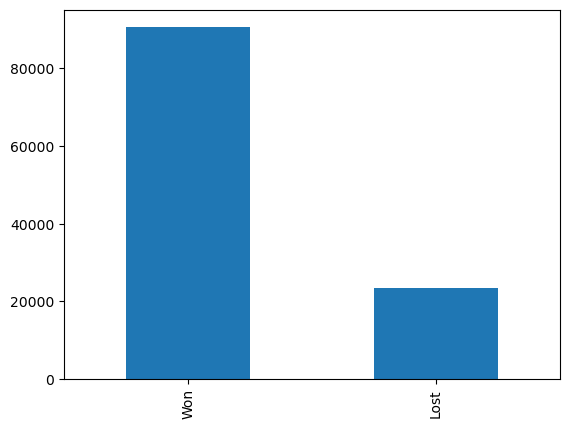

In [37]:
df_classification['status'].value_counts().plot(kind='bar')

C:\Users\THIRUMURUGAN\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression - Accuracy: 0.7900, F1 Score: 0.8800, ROC AUC: 0.5325
KNeighbors - Accuracy: 0.8561, F1 Score: 0.9110, ROC AUC: 0.7559
AdaBoost - Accuracy: 0.8133, F1 Score: 0.8900, ROC AUC: 0.6161
Decision Tree - Accuracy: 0.9169, F1 Score: 0.9477, ROC AUC: 0.8741
GaussianNB - Accuracy: 0.7792, F1 Score: 0.8658, ROC AUC: 0.6118
Random Forest - Accuracy: 0.9386, F1 Score: 0.9620, ROC AUC: 0.8843
Extra Trees - Accuracy: 0.9332, F1 Score: 0.9587, ROC AUC: 0.8729
XGBoost - Accuracy: 0.8989, F1 Score: 0.9382, ROC AUC: 0.8043


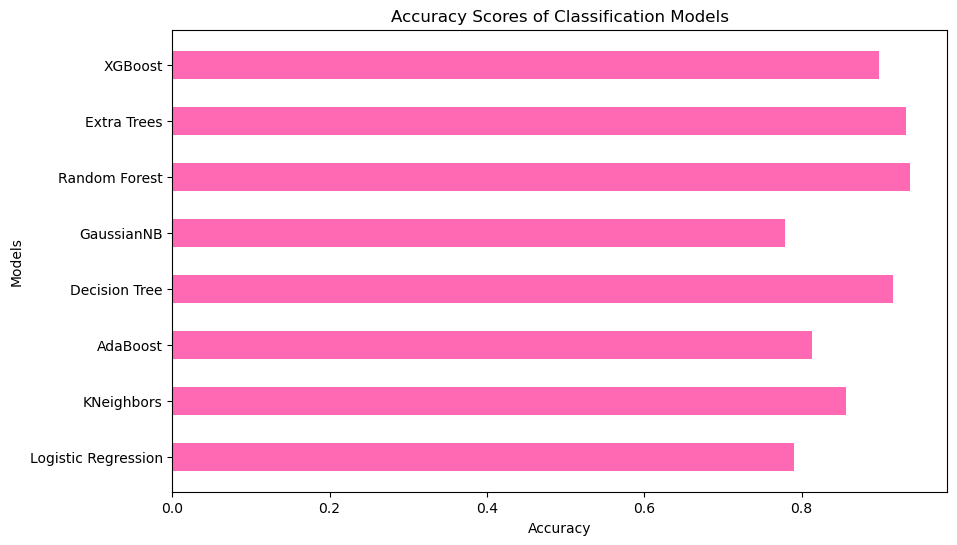

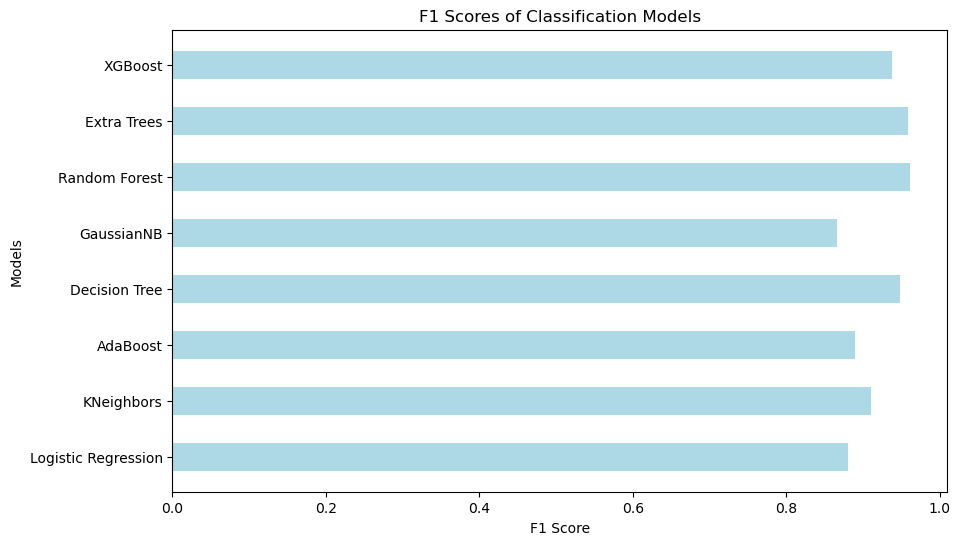

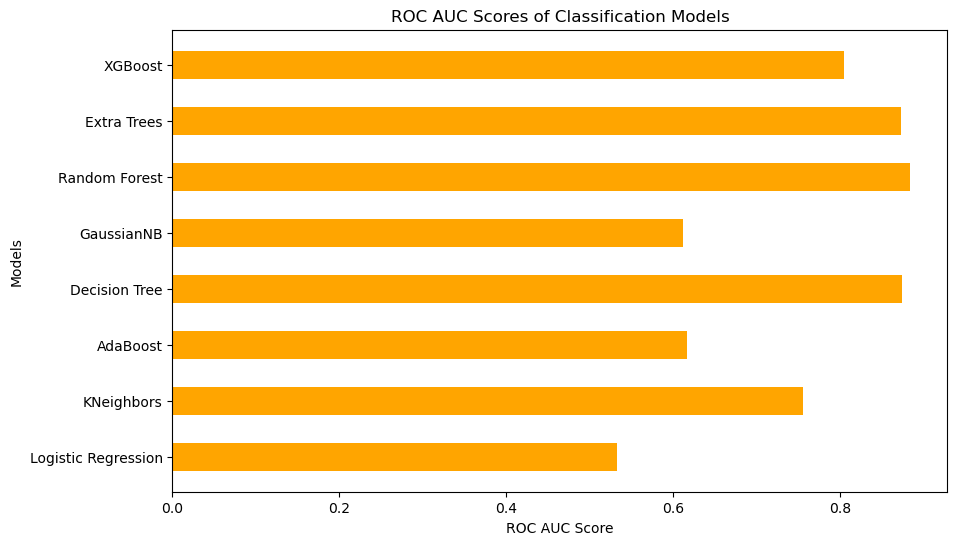

Logistic Regression - Confusion Matrix:
[[  453  4206]
 [  585 17565]]


KNeighbors - Confusion Matrix:
[[ 2733  1926]
 [ 1357 16793]]


AdaBoost - Confusion Matrix:
[[ 1317  3342]
 [  916 17234]]


Decision Tree - Confusion Matrix:
[[ 3735   924]
 [  971 17179]]


GaussianNB - Confusion Matrix:
[[ 1532  3127]
 [ 1909 16241]]


Random Forest - Confusion Matrix:
[[ 3692   967]
 [  434 17716]]


Extra Trees - Confusion Matrix:
[[ 3592  1067]
 [  457 17693]]


XGBoost - Confusion Matrix:
[[ 3002  1657]
 [  648 17502]]


Predicted Status: Won


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
x=df_classification[['quantity_tons','country','application','thickness','width','selling_price','delivery_period']].values
y=df_classification[['status']].values

le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize the scaler and fit it on the training data
scaler = StandardScaler().fit(X_train)

# Save the scaler using pickle
with open('scaling_classification.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Transform both training and testing data using the scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the classification models
models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    AdaBoostClassifier(),
    DecisionTreeClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    XGBClassifier()
]

# Train and evaluate each model
model_names = ['Logistic Regression', 'KNeighbors', 'AdaBoost', 'Decision Tree', 'GaussianNB', 'Random Forest',
               'Extra Trees', 'XGBoost']
accuracy_scores = []
f1_scores = []
roc_auc_scores = []
conf_matrices = []
for model, model_name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    conf_matrices.append(conf_matrix)
    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# Create the bar plot for accuracy scores
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracy_scores, height=0.5, color="hotpink")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.title("Accuracy Scores of Classification Models")

plt.show()

# Create the bar plot for F1 scores
plt.figure(figsize=(10, 6))
plt.barh(model_names, f1_scores, height=0.5, color="lightblue")
plt.xlabel("F1 Score")
plt.ylabel("Models")
plt.title("F1 Scores of Classification Models")

plt.show()

# Create the bar plot for ROC AUC scores
plt.figure(figsize=(10, 6))
plt.barh(model_names, roc_auc_scores, height=0.5, color="orange")
plt.xlabel("ROC AUC Score")
plt.ylabel("Models")
plt.title("ROC AUC Scores of Classification Models")

plt.show()

# Display confusion matrices for each model
for model_name, conf_matrix in zip(model_names, conf_matrices):
    print(f"{model_name} - Confusion Matrix:")
    print(conf_matrix)
    print('\n')

# Use the trained model for prediction
# Replace 'new_data' with the input data for prediction (excluding 'STATUS')
new_data = X_test[0].reshape(1, -1)  # Example: Using the first data point from the test set
new_data_scaled = scaler.transform(new_data)

# Choose the best model from your evaluation (e.g., RandomForestClassifier in this example)
best_model = RandomForestClassifier()

# Train the best model on the entire dataset (including both training and testing data)
best_model.fit(X_train, y_train)

# Make predictions using the new data
predicted_status = best_model.predict(new_data_scaled)

# Decode the predicted status using the LabelEncoder
predicted_status = le.inverse_transform(predicted_status)

print(f"Predicted Status: {predicted_status[0]}")

In [ ]:
new_data = X_test[0].reshape(1, -1)  # Example: Using the first data point from the test set
new_data_scaled = scaler.transform(new_data)

# Choose the best model from your evaluation (e.g., RandomForestClassifier in this example)
best_model = RandomForestClassifier()

# Train the best model on the entire dataset (including both training and testing data)
best_model.fit(X_train, y_train)

# Make predictions using the new data
predicted_status = best_model.predict(new_data_scaled)

# Decode the predicted status using the LabelEncoder
predicted_status = le.inverse_transform(predicted_status)

print(f"Predicted Status: {predicted_status[0]}")

# Save the trained model using pickle
with open('classification.pkl', 'wb') as f:
    pickle.dump(best_model, f)